# **Machine Learning on Big Data (CN7030) CRWK 21-22 [60 marks]**
# **Group ID: 23**
1.   Student 1: Siddharth Dholu - u2165171
2.   Student 2: Param Jogidas - u2187104

---
#####Module leader: **Dr Amin Karami** (a.karami@uel.ac.uk)

If you want to add comments on your group work, please write it here for us:


# **Initiate and Configure Spark**

---


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [4]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 50.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=78f996910e982accd79dd6a739fe36d9aac755269c0f5176a43992c9d6138ac7
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [5]:
from pyspark.sql.types import StructType, BinaryType, StringType, IntegerType, FloatType, DoubleType, TimestampType
import pandas as pd

In [6]:
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("GroupID-23") \
    .getOrCreate()

### User Define Class & Functions

In [87]:
# Creating dictionary for adding each model accuracy, confusion matrix,
# report that include F1 Score, Recall and Precision
mapAccuracy = {}
mapReport = {}
listConfusionMatrix = [] 

In [88]:
# Class for custom list for confusion matrix
# In this class list we have classification name, matrix and classes (labels)
class ClassifiersConfusionMatrix: 
    def __init__(self, name, confusionMetrics, classes): 
        self.name = name 
        self.confusionMetrics = confusionMetrics
        self.classes = classes

In [89]:
# Function for ploting the accuracy with bar chart
def plotAccuracy(data):
  
  # To import library for plotting the chart
  import matplotlib.pyplot as plt
  import numpy as np

  # Saperating lines and word counts to labels and values
  # labels = list(data.keys())
  # values = list(data.values())
  
  labels = np.array(list(data.keys()))
  values = np.array(list(data.values()))


  # Plotting the chart
  fig = plt.figure(figsize=(6,4))
  ax = fig.add_axes([0,0,1,1])
  ax.barh(labels,values)
  plt.title("Prediction Accuracy")
  plt.ylabel("Classifiers")
  plt.xlabel("Accuracy")

  # plt.xlim([values.min() - 1, values.max() + 1])
  plt.xlim([80, 100])
  # plt.xticks(np.arange(values.min() - 2, values.max() + 2, 5))
  plt.xticks(np.arange(80, 100, 5))
  

  for i, accu in enumerate(values):
    plt.text(s=str(accu)+" %", x=accu-3, y=i, color="w",
             verticalalignment="center", horizontalalignment="left", size=14)
  plt.show()

In [90]:
# Function to create confusion matrix from predictions
def createConfusionMatrix(classifierName, isBinaryClassifier, predictions, label ,targetLabel='label', predictedLabel='prediction'):
  from sklearn.metrics import confusion_matrix
  
  class_temp = predictions.select(label).groupBy(label)\
                        .count().sort('count', ascending=False).toPandas()
  class_temp = class_temp[label].values.tolist()

  classes = list(map(str, class_temp))
  if isBinaryClassifier:
    classes = list(map(lambda x: x.replace('0.0', 'Normal'), classes))
    classes = list(map(lambda x: x.replace('1.0', 'Attack'), classes))

  from pyspark.mllib.evaluation import MulticlassMetrics
  predAndLabel = predictions[predictedLabel, targetLabel]
  predAndLabel = predAndLabel.withColumn(targetLabel,predAndLabel[targetLabel].cast(DoubleType()))
  metrics = MulticlassMetrics(predAndLabel.rdd)
  cnf_matrix = metrics.confusionMatrix().toArray()

  # appending instances to list 
  listConfusionMatrix.append(ClassifiersConfusionMatrix(classifierName, cnf_matrix, classes))

In [91]:
# Importing required library for ploting the graph
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Function to plot classification's confusion matrix with normalization
def plot_confusion_matrix(data, normalize=True, cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(20, 16))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for index, item in enumerate(data, start=1):
        ax = fig.add_subplot(2, 2, index)

        title = item.name
        classes = item.classes
        cm = item.confusionMetrics

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        # else:
            # print('Confusion matrix, without normalization')

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        # plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel(f'Predicted Label \n Figure[{index}]')
        
    fig.tight_layout()
    plt.show()

In [205]:
# Function to print classification report that includes f1 score, precision and recall
def showClassificationReport(data):
  
  #Importing libaries for classification report
  import warnings
  from sklearn.metrics import classification_report
  import numpy as np
  
  warnings.filterwarnings('ignore')

  keys = list(data.keys())

  for key in keys:
    if key == 'Logistic Regression (Binary Classifier)':
      print(f'---------------------------------------------------------------------')
      print(f'{key}')
      print(f'---------------------------------------------------------------------')
      y_pred = data[key].select('prediction').rdd.flatMap(lambda x: x).collect()
      y_true = data[key].select('Label').rdd.flatMap(lambda x: x).collect()
      classes = [0,1]
      print(classification_report(y_true, y_pred, labels=classes))
      print('\n')
    else:
      print(f'---------------------------------------------------------------------')
      print(f'{key}')
      print(f'---------------------------------------------------------------------')
      y_pred = data[key].select('prediction').rdd.flatMap(lambda x: x).collect()
      y_true = data[key].select('idx_attack_cat').rdd.flatMap(lambda x: x).collect()

      lenYPred = len(y_pred)
      lenYTrue = len(y_true)
      if lenYPred != lenYTrue:
        if lenYPred > lenYTrue:
          y_pred = y_pred[0:lenYTrue]
        else:
          y_true = y_true[0:lenYPred]

      classes = ['Normal', 'Generic', 'Exploits', 'Fuzzers ', 'DoS', 'Reconnaissance ', 'Fuzzers', 'Analysis', 'Backdoor', 'Reconnaissance', 'Shellcode ', 'Backdoors', 'Shellcode', 'Worms']
      print(classification_report(y_true, y_pred, target_names=classes))
      print('\n')


# **Load Data**

---


In [93]:
columnNames = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", 
               "sloss", "dloss", "service", "Sload", "Dload", "Spkts", "Dpkts", "swin", "dwin", "stcpb", "dtcpb", 
               "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt",
               "tcprtt", "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd",
               "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm",
               "attack_cat", "Label"]

schema = StructType() \
      .add("srcip",StringType(),True) \
      .add("sport",IntegerType(),True) \
      .add("dstip",StringType(),True) \
      .add("dsport",IntegerType(),True) \
      .add("proto",StringType(),True) \
      .add("state",StringType(),True) \
      .add("dur",FloatType(),True) \
      .add("sbytes",IntegerType(),True) \
      .add("dbytes",IntegerType(),True) \
      .add("sttl",IntegerType(),True) \
      .add("dtt1",IntegerType(),True) \
      .add("sloss",IntegerType(),True) \
      .add("dloss",IntegerType(),True) \
      .add("service",StringType(),True) \
      .add("Sload",FloatType(),True) \
      .add("Dload",FloatType(),True) \
      .add("Spkts",IntegerType(),True) \
      .add("Dpkts",IntegerType(),True) \
      .add("swin",IntegerType(),True) \
      .add("dwin",IntegerType(),True) \
      .add("stcpb",IntegerType(),True) \
      .add("dtcpb",IntegerType(),True) \
      .add("smeansz",IntegerType(),True) \
      .add("dmeansz",IntegerType(),True) \
      .add("trans_depth",IntegerType(),True) \
      .add("res_bdy_len",IntegerType(),True) \
      .add("Sjit",FloatType(),True) \
      .add("Djit",FloatType(),True) \
      .add("Stime",StringType(),True) \
      .add("Ltime",StringType(),True) \
      .add("Sintpkt",FloatType(),True) \
      .add("Dintpkt",FloatType(),True) \
      .add("tcprtt",FloatType(),True) \
      .add("synack",FloatType(),True) \
      .add("ackdat",FloatType(),True) \
      .add("is_sm_ips_ports",IntegerType(),True) \
      .add("ct_state_ttl",IntegerType(),True) \
      .add("ct_flw_http_mthd",IntegerType(),True) \
      .add("is_ftp_login",IntegerType(),True) \
      .add("ct_ftp_cmd",IntegerType(),True) \
      .add("ct_srv_src",IntegerType(),True) \
      .add("ct_srv_dst",IntegerType(),True) \
      .add("ct_dst_ltm",IntegerType(),True) \
      .add("ct_src_ltm",IntegerType(),True) \
      .add("ct_src_dport_ltm",IntegerType(),True) \
      .add("ct_dst_sport_ltm",IntegerType(),True) \
      .add("ct_dst_src_ltm",IntegerType(),True) \
      .add("attack_cat",StringType(),True) \
      .add("Label",IntegerType(),True) \


rawData = spark.read.csv("/content/drive/MyDrive/PythonProjectResources/CN7030/UNSW-NB15.csv", inferSchema=True, schema=schema)

In [ ]:
rawData.printSchema()

root
 |-- srcip: string (nullable = true)
 |-- sport: integer (nullable = true)
 |-- dstip: string (nullable = true)
 |-- dsport: integer (nullable = true)
 |-- proto: string (nullable = true)
 |-- state: string (nullable = true)
 |-- dur: float (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dtt1: integer (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- service: string (nullable = true)
 |-- Sload: float (nullable = true)
 |-- Dload: float (nullable = true)
 |-- Spkts: integer (nullable = true)
 |-- Dpkts: integer (nullable = true)
 |-- swin: integer (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- stcpb: integer (nullable = true)
 |-- dtcpb: integer (nullable = true)
 |-- smeansz: integer (nullable = true)
 |-- dmeansz: integer (nullable = true)
 |-- trans_depth: integer (nullable = true)
 |-- res_bdy_len: integer (nullable = true)
 |-

In [ ]:
rawData.columns

['srcip',
 'sport',
 'dstip',
 'dsport',
 'proto',
 'state',
 'dur',
 'sbytes',
 'dbytes',
 'sttl',
 'dtt1',
 'sloss',
 'dloss',
 'service',
 'Sload',
 'Dload',
 'Spkts',
 'Dpkts',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'smeansz',
 'dmeansz',
 'trans_depth',
 'res_bdy_len',
 'Sjit',
 'Djit',
 'Stime',
 'Ltime',
 'Sintpkt',
 'Dintpkt',
 'tcprtt',
 'synack',
 'ackdat',
 'is_sm_ips_ports',
 'ct_state_ttl',
 'ct_flw_http_mthd',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'attack_cat',
 'Label']

In [ ]:
rawData.show(20)

+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+--------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+---------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dtt1|sloss|dloss| service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt|  Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+----------+-----+-------------+------+-----+---

# **Data Preprocess & Feature Selection**

Extraacting the feature by filtering the columns by its importance to target or label column.

*Feature Column Names and Description*
*   **srcip**: Source IP Address
*   **dstip**: Destination IP Address
*   **proto**: Transaction protocol
*   **state**: Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR, REQ, RST, TST, TXD, URH, URN, and (-) (if not used state)
*   **sttl**: Source to destination time to live value
*   **dttl**: Destination to source time to live value
*   **service**: http, ftp, smtp, ssh, dns, ftp-data ,irc  and (-) if not much used service
*   **swin**: Source TCP window advertisement value
*   **dwin**: Destination TCP window advertisement value
*   **smeansz**: Mean of the row packet size transmitted by the source
*   **smeansz**: Mean of the ?ow packet size transmitted by the destination
*   **trans_depth**: Represents the pipelined depth into the connection of http request/response transaction
*   **res_bdy_len**: Actual uncompressed content size of the data transferred from the serverís http service
*   **ct_flw_http_mthd**: No. of flows that has methods such as Get and Post in http service
*   **is_ftp_login**: If the ftp session is accessed by user and password then 1 else 0
*   **ct_ftp_cmd**: No of flows that has a command in ftp session

*Label (Target) Column Name and Description*
*   **Label**: 0 for normal (No attack) and 1 for attack records



In [94]:
# dropCols = ["stcpb","dtcpb", "ackdat", "sport", "dsport", "dur", "sbytes", "dbytes", "sloss", "dloss","Sload","Dload", "Sjit",
#              "Djit","Sintpkt","Dintpkt","tcprtt","synack", "Spkts","Dpkts", "Stime", "Ltime", "attack_cat"]
# df = rawData.na.fill(value="NA",subset=["attack_cat"]).drop(str(dropCols))
# df = rawData.drop("stcpb","dtcpb", "ackdat", "sport", "dsport", "dur", "sbytes", "dbytes", "sloss", "dloss","Sload","Dload", "Sjit",
#              "Djit","Sintpkt","Dintpkt","tcprtt","synack", "Spkts","Dpkts", "Stime", "Ltime", "attack_cat")

filteredCols = ['srcip', 'dstip', 'proto', 'state', 'sttl', 'dtt1', 'service', 'swin', 'dwin', 
                'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 
                'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'Label']
df = rawData[filteredCols]
df.show()

+----------+-------------+-----+-----+----+----+--------+----+----+-------+-------+-----------+-----------+----------------+------------+----------+-----+
|     srcip|        dstip|proto|state|sttl|dtt1| service|swin|dwin|smeansz|dmeansz|trans_depth|res_bdy_len|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|Label|
+----------+-------------+-----+-----+----+----+--------+----+----+-------+-------+-----------+-----------+----------------+------------+----------+-----+
|59.166.0.3|149.171.126.8|  tcp|  FIN|  31|  29|       -| 255| 255|     64|    129|          0|          0|               0|           0|         0|    0|
|59.166.0.0|149.171.126.6|  tcp|  FIN|  31|  29|       -| 255| 255|     59|    887|          0|          0|               0|           0|         0|    0|
|59.166.0.5|149.171.126.2|  tcp|  FIN|  31|  29|       -| 255| 255|     63|    606|          0|          0|               0|           0|         0|    0|
|59.166.0.9|149.171.126.0|  tcp|  FIN|  31|  29|       -| 255| 255|   

Checking the null data from entire pyspark dataframe with the help of SQL Functions.




In [ ]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+-----+-----+-----+-----+----+----+-------+----+----+-------+-------+-----------+-----------+----------------+------------+----------+-----+
|srcip|dstip|proto|state|sttl|dtt1|service|swin|dwin|smeansz|dmeansz|trans_depth|res_bdy_len|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|Label|
+-----+-----+-----+-----+----+----+-------+----+----+-------+-------+-----------+-----------+----------------+------------+----------+-----+
|    0|    0|    0|    0|   0|   0|      0|   0|   0|      0|      0|          0|          0|               0|           0|         0|    0|
+-----+-----+-----+-----+----+----+-------+----+----+-------+-------+-----------+-----------+----------------+------------+----------+-----+



We need to check the column data type in order to get Feature to Label correlation metrics. It must be in Integer data type before we proceed for correlation metrics. Following "for loop" has written to extract the string data type columns name from pyspark dataframe.

In [95]:
string_col = []
for col in df.dtypes:
    if col[1] == "string" :
      string_col.append(col[0])
print(string_col)

['srcip', 'dstip', 'proto', 'state', 'service']


After identifying the strign columns ('srcip', 'dstip', 'proto', 'state', 'service'), we need to convert those columns values into numeric or integer data type. For that we need to import requied libraries from "pyspark.ml".

**StringIndexer**: StringIndexer is a feature from "pyspark.ml" library which converts distinc label (categorical) data into numeric data. It indexes the string values. As its perameters, it ask for "inputCol" where we need to pass string type column name and also we need to give newly generated strign index column name in "outputCol".

In [96]:
from pyspark.ml.feature import StringIndexer

for column_name in list(string_col):
  stringIndexer = StringIndexer(inputCol=column_name, outputCol="idx_"+column_name)
  model = stringIndexer.fit(df)
  df = model.transform(df)

df = df.drop('srcip', 'dstip', 'proto', 'state', 'service')
df.show()

+----+----+----+----+-------+-------+-----------+-----------+----------------+------------+----------+-----+---------+---------+---------+---------+-----------+
|sttl|dtt1|swin|dwin|smeansz|dmeansz|trans_depth|res_bdy_len|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|Label|idx_srcip|idx_dstip|idx_proto|idx_state|idx_service|
+----+----+----+----+-------+-------+-----------+-----------+----------------+------------+----------+-----+---------+---------+---------+---------+-----------+
|  31|  29| 255| 255|     64|    129|          0|          0|               0|           0|         0|    0|      5.0|      9.0|      0.0|      0.0|        0.0|
|  31|  29| 255| 255|     59|    887|          0|          0|               0|           0|         0|    0|      4.0|      8.0|      0.0|      0.0|        0.0|
|  31|  29| 255| 255|     63|    606|          0|          0|               0|           0|         0|    0|      2.0|      1.0|      0.0|      0.0|        0.0|
|  31|  29| 255| 255|     58|   12

As above, we can see that now we have converted string values into numeric values. Now our pyspark dataframe is suitable for correlation metrics and model building. For correlation metrics, easiest way to convert pyspark dataframe into pandas dataframe because pandas dataframe has "corr()" method which calculates the correlation among the features and label. In result we can find the values between 0 to 1. Values which are closer to 1 is highly effectable to label column and for that we need to sort the values by "Label" which is our label (target) class.

In [ ]:
df.toPandas().corr().sort_values(by='Label', ascending = False)

,sttl,dtt1,swin,dwin,smeansz,dmeansz,trans_depth,res_bdy_len,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,Label,idx_srcip,idx_dstip,idx_proto,idx_state,idx_service
Label,0.904411,0.134921,-0.315194,-0.314005,-0.065364,-0.272449,-0.029052,-0.027343,-0.026571,-0.031828,-0.029660,1.000000,0.395100,0.555198,0.217209,0.479904,-0.003985
sttl,1.000000,0.113994,-0.352275,-0.357925,-0.056387,-0.333016,-0.062366,-0.036785,-0.056658,-0.049769,-0.043434,0.904411,0.466332,0.616260,0.215505,0.557033,-0.054863
idx_dstip,0.616260,0.179993,-0.332341,-0.338682,0.006324,-0.319257,-0.041992,-0.033947,-0.029888,-0.041285,-0.037437,0.555198,0.659435,1.000000,0.196894,0.535596,-0.047242
idx_state,0.557033,-0.354532,-0.892591,-0.899108,-0.126211,-0.558772,-0.180784,-0.067209,-0.149755,-0.098733,-0.084689,0.479904,0.585953,0.535596,0.201626,1.000000,-0.104481
idx_srcip,0.466332,0.030824,-0.381008,-0.384774,0.005266,-0.324315,-0.061485,-0.034536,-0.052061,-0.045543,-0.040029,0.395100,1.000000,0.659435,0.119364,0.585953,-0.032470
idx_proto,0.215505,-0.078432,-0.169301,-0.168832,-0.023613,-0.108005,-0.033666,-0.012640,-0.028000,-0.018401,-0.015782,0.217209,0.119364,0.196894,1.000000,0.201626,-0.063962
dtt1,0.113994,1.000000,0.305248,0.306875,0.098766,0.046675,0.117849,0.007926,0.102594,0.028129,0.019644,0.134921,0.030824,0.179993,-0.078432,-0.354532,0.042320
idx_service,-0.054863,0.042320,0.128788,0.130623,0.352166,-0.151222,0.156437,0.063277,0.097474,0.384234,0.329153,-0.003985,-0.032470,-0.047242,-0.063962,-0.104481,1.000000
ct_flw_http_mthd,-0.056658,0.102594,0.165384,0.165843,-0.002266,0.170166,0.576086,0.169793,1.000000,-0.025724,-0.022063,-0.026571,-0.052061,-0.029888,-0.028000,-0.149755,0.097474
res_bdy_len,-0.036785,0.007926,0.074651,0.074858,-0.039310,0.298569,0.233826,1.000000,0.169793,-0.011613,-0.009960,-0.027343,-0.034536,-0.033947,-0.012640,-0.067209,0.063277


We can see above correlation metrics and we can find easily which are more important feature to our label class.

Features which are closer to one is more likely importance, in this case we found following features:

**sttl, idx_dstip, idx_state, idx_scrip, idx_proto and dttl**

We would be building prediction model with the help of above fetaures.

# **Task 1 - Binary Classifier [20 marks]**

We have filtered out the most important features and assign into same variable.

In [97]:
df = df['sttl', 'idx_dstip','idx_state','idx_srcip','idx_proto','dtt1', 'Label']
df.show(5)

+----+---------+---------+---------+---------+----+-----+
|sttl|idx_dstip|idx_state|idx_srcip|idx_proto|dtt1|Label|
+----+---------+---------+---------+---------+----+-----+
|  31|      9.0|      0.0|      5.0|      0.0|  29|    0|
|  31|      8.0|      0.0|      4.0|      0.0|  29|    0|
|  31|      1.0|      0.0|      2.0|      0.0|  29|    0|
|  31|      5.0|      0.0|      6.0|      0.0|  29|    0|
|  31|      6.0|      0.0|      8.0|      0.0|  29|    0|
+----+---------+---------+---------+---------+----+-----+
only showing top 5 rows



We are checking the balance of two classes '0' and '1' where 0 means Normal (No attack) and 1 means attack. In below result we found that 0 has major records and 1 has minor. It means the dataset is imbalance, so we need to train our model with weight of minor and major classes.

In [35]:
df.groupBy('Label').count().show()

+-----+-------+
|Label|  count|
+-----+-------+
|    1| 321283|
|    0|2218456|
+-----+-------+



In order to train the model from pyspark dataframe we must need to convert the the dataframe into required format before train the data to its model. And it requires VectorAssembler format for that we have library which we can use it from pyspark.ml.feature.

While converting dataset into vectorassembler format we must remove the targeted column in inputCols, and in outputCol we need to pass the name of which vector assembler generates the data from given data. In our case we have given 'features' which is standard name for output column.

In [98]:
from pyspark.ml.feature import VectorAssembler
cols = ['sttl', 'idx_dstip','idx_state','idx_srcip','idx_proto','dtt1']

assembler = VectorAssembler(inputCols=cols,outputCol="features")
# Now let us use the transform method to transform our dataset
dataset=assembler.transform(df)
dataset.select("features").show(truncate=False)

+---------------------------+
|features                   |
+---------------------------+
|[31.0,9.0,0.0,5.0,0.0,29.0]|
|[31.0,8.0,0.0,4.0,0.0,29.0]|
|[31.0,1.0,0.0,2.0,0.0,29.0]|
|[31.0,5.0,0.0,6.0,0.0,29.0]|
|[31.0,6.0,0.0,8.0,0.0,29.0]|
|[31.0,0.0,0.0,5.0,0.0,29.0]|
|[31.0,5.0,1.0,9.0,1.0,29.0]|
|[31.0,6.0,0.0,5.0,0.0,29.0]|
|[31.0,1.0,1.0,6.0,1.0,29.0]|
|[31.0,4.0,1.0,9.0,1.0,29.0]|
|[31.0,7.0,1.0,1.0,1.0,29.0]|
|[31.0,6.0,0.0,4.0,0.0,29.0]|
|[31.0,0.0,0.0,1.0,0.0,29.0]|
|[31.0,9.0,1.0,8.0,1.0,29.0]|
|[31.0,9.0,1.0,8.0,1.0,29.0]|
|[31.0,1.0,1.0,8.0,1.0,29.0]|
|[31.0,2.0,1.0,1.0,1.0,29.0]|
|[31.0,1.0,1.0,5.0,1.0,29.0]|
|[31.0,6.0,0.0,4.0,0.0,29.0]|
|[31.0,2.0,0.0,4.0,0.0,29.0]|
+---------------------------+
only showing top 20 rows



We used StandardScaler feature from pyspark.ml library which converts the large value data into 0 to 1 value. With the help of it and our model training gets faster and more efficent. Here we passed vector assembler data to stander scaler and in return it will create new scaled data which we have given name of that column is 'Scaled_featueres'.

In [99]:
#Standard Sclarizer
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
dataset=standardscaler.fit(dataset).transform(dataset)
dataset.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[31.0,9.0,0.0,5.0...|[0.41540092459202...|
|[31.0,8.0,0.0,4.0...|[0.41540092459202...|
|[31.0,1.0,0.0,2.0...|[0.41540092459202...|
|[31.0,5.0,0.0,6.0...|[0.41540092459202...|
|[31.0,6.0,0.0,8.0...|[0.41540092459202...|
+--------------------+--------------------+
only showing top 5 rows



Split the dataset to test and train data. We create the model on the train dataset and then test it on the test dataset.

In [100]:
train, test = dataset.randomSplit([0.7, 0.3], seed=12345)

 The number of examples in one class in our dataset is significantly greater than the examples in the other class. This is called imbalanced data set.

In [101]:
#imbalance in the dataset, observe the use of Where
dataset_size=float(train.select("Label").count())
numPositives=train.select("Label").where('Label == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 224985
Percentage of ones are 12.654137672698312


In [102]:
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.8734586232730169


Here, balancingratio is almost 2/7.

In [103]:
from pyspark.sql.functions import when
# balance 
train=train.withColumn("classWeights", when(train.Label == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+-------------------+
|       classWeights|
+-------------------+
|0.12654137672698307|
| 0.8734586232730169|
| 0.8734586232730169|
| 0.8734586232730169|
| 0.8734586232730169|
+-------------------+
only showing top 5 rows



With the classweight, the model assigns half the instances to each class (even the less commmon one).

In [104]:
#Building a classification model using Logistic Regression (LR)
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Label", featuresCol="Scaled_features",weightCol="classWeights",maxIter=10)
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("Label","prediction").show(10)

+-----+----------+
|Label|prediction|
+-----+----------+
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 10 rows



Logistic Regression is to understand the relationship between the dependent variable and one or more independent variables by estimating probabilities using a logistic regression equation. Here, we have onle one label for prediction. So, we use LR in bainary classification.

In [105]:
#Evaluating the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator=BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol="Label")
# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(predict_test, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve: {:.4f}".format(auroc))
predict_test.select("Label","prediction","probability").show(15)

# Adding accuracy and test prediction into list for data visulization or plotting
mapAccuracy["Logistic Regression (Binary Classifier)"] = (float("{:.4}".format(auroc)) * 100)
mapReport["Logistic Regression (Binary Classifier)"] = predict_test
createConfusionMatrix(classifierName='Logistic Regression (Binary Classifier)',
                      predictions=predict_test,
                      isBinaryClassifier=True,
                      label="Label",
                      targetLabel="Label",
                      predictedLabel="prediction")


Area under ROC Curve: 0.9899
+-----+----------+--------------------+
|Label|prediction|         probability|
+-----+----------+--------------------+
|    1|       0.0|[0.98628362700344...|
|    1|       0.0|[0.98628362700344...|
|    1|       0.0|[0.98628362700344...|
|    1|       0.0|[0.98503037533840...|
|    1|       0.0|[0.98503037533840...|
|    1|       0.0|[0.98503037533840...|
|    1|       0.0|[0.98503037533840...|
|    1|       0.0|[0.98436211228654...|
|    1|       0.0|[0.98436211228654...|
|    1|       0.0|[0.98436211228654...|
|    1|       0.0|[0.98362514996675...|
|    1|       0.0|[0.98362514996675...|
|    1|       0.0|[0.98362514996675...|
|    1|       0.0|[0.98362514996675...|
|    1|       0.0|[0.98213339603638...|
+-----+----------+--------------------+
only showing top 15 rows



Once we create the model. It is very important to evaluate the accuracy of the model to understand whether it is important to implement it or not. ROC curve is one of the important evaluation methods. ROC curve is a probability curve that plots the True positive rate against the false positive rate. Here, True positive rate is the number of predictions where the model was successful in predicting the outcome correctly.


# **Task 2 - Multi Classifier [25 marks]**

---


In [120]:
# Fetching the records which have 1 label or Attack
minor_class_df = rawData.filter(rawData.Label == 1)
minor_class_df.show(10)

+------------+-----+--------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+---------+--------+--------+--------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+---------------+-----+
|       srcip|sport|         dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dtt1|sloss|dloss|service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt|  Dintpkt|  tcprtt|  synack|  ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|     attack_cat|Label|
+------------+-----+--------

In [121]:
# Fetching the records which have 0 label or Normal (No Attack)
# Under sampling the data frame to balance the minor and major class
major_class_df = rawData.filter(rawData.Label == 0)
major_class_df = major_class_df.limit(minor_class_df.count())
major_class_df.show(10)

+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+--------+---------+---------+-----+-----+----+----+---------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+--------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dtt1|sloss|dloss| service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|    stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt| Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+----------+-----+-------------+------+-----+-----+-

In [122]:
# Merging the minor class and major class dataframe into df
df = minor_class_df.union(major_class_df)
print(df.count())
df.show(10)

642566
+------------+-----+--------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+---------+--------+--------+--------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+---------------+-----+
|       srcip|sport|         dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dtt1|sloss|dloss|service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt|  Dintpkt|  tcprtt|  synack|  ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|     attack_cat|Label|
+------------+-----+-

In [123]:
# Shuffeling the records for better data spliting
from pyspark.sql.functions import rand
df = df.orderBy(rand())
df.show(10)

+------------+-----+--------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+-----------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+---------+--------+--------+--------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+---------------+-----+
|       srcip|sport|         dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dtt1|sloss|dloss|service|      Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt|  Dintpkt|  tcprtt|  synack|  ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|     attack_cat|Label|
+------------+-----+----

In [127]:
# Filtering the columns
filteredCols = ['srcip', 'dstip', 'state', 'sttl', 'dtt1', 'service', 'swin', 'dwin', 
                'trans_depth', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'attack_cat']
df = df[filteredCols]

# Filling the null values with the value of "Normal" to "attack_cat" column
df = df.na.fill(subset=['attack_cat'], value='Normal')
df.groupBy('attack_cat').count().show()

+---------------+------+
|     attack_cat| count|
+---------------+------+
|          Worms|   174|
|       Analysis|  2677|
|     Shellcode |  1288|
|            DoS| 16353|
|Reconnaissance | 12228|
|       Backdoor|  1795|
|       Fuzzers | 19195|
|       Exploits| 44525|
|        Generic|215481|
|      Shellcode|   223|
|      Backdoors|   534|
|        Fuzzers|  5051|
| Reconnaissance|  1759|
|         Normal|321283|
+---------------+------+



In [128]:
# Creating "for loop" for counting each column's distinct values
for col in df.columns:
  print(f'{col} : {df.select(col).distinct().count()}')

srcip : 40
dstip : 45
state : 15
sttl : 13
dtt1 : 9
service : 13
swin : 15
dwin : 11
trans_depth : 14
ct_flw_http_mthd : 12
is_ftp_login : 4
ct_ftp_cmd : 4
attack_cat : 14


In [129]:
# Importing StringIndexer package from pyspark to convert string data into integer value
from pyspark.ml.feature import StringIndexer

# Identifiying the string data type columns and adding into string_col[] list
string_col = []
for col in df.dtypes:
    if col[1] == "string":
      string_col.append(col[0])
print(f'''{string_col}
      
      ''')

# Implementing the StringIndexer to string data type columns one by one
for column_name in list(string_col):
  stringIndexer = StringIndexer(inputCol=column_name, outputCol="idx_"+column_name)
  model = stringIndexer.fit(df)
  df = model.transform(df)

# Droping the string type columns from spark data frame
df = df.drop('srcip', 'dstip', 'state', 'service')

# Importing VectorAssembler to convert all feature columns into vector format to build the model
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler( inputCols=['idx_srcip', 'idx_dstip', 'idx_state', 'sttl', 'dtt1', 'idx_service', 'swin', 'dwin', 
                'trans_depth',
                'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd'], outputCol="features")

df = vector_assembler.transform(df)
df.show(3)

['srcip', 'dstip', 'state', 'service', 'attack_cat']
      
      
+----+----+----+----+-----------+----------------+------------+----------+----------+---------+---------+---------+-----------+--------------+--------------------+
|sttl|dtt1|swin|dwin|trans_depth|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|attack_cat|idx_srcip|idx_dstip|idx_state|idx_service|idx_attack_cat|            features|
+----+----+----+----+-----------+----------------+------------+----------+----------+---------+---------+---------+-----------+--------------+--------------------+
|  31|  29|   0|   0|          0|               0|           0|         0|    Normal|     11.0|     13.0|      2.0|        0.0|           0.0|(12,[0,1,2,3,4],[...|
|  31|  29| 255| 255|          0|               0|           0|         0|    Normal|      5.0|     13.0|      1.0|        4.0|           0.0|[5.0,13.0,1.0,31....|
|  31|  29|   0|   0|          0|               0|           0|         0|    Normal|      3.0|     11.0|      2.

In [130]:
# Selecting only "attack_cat", "idx_attack_cat" and "features" from data frame
# Spliting into features and label data frame for future use
df = df['attack_cat','idx_attack_cat','features']
df_feature = df['features']
df_indexLabel = df['idx_attack_cat']
df.show()

+---------------+--------------+--------------------+
|     attack_cat|idx_attack_cat|            features|
+---------------+--------------+--------------------+
|         Normal|           0.0|(12,[0,1,2,3,4],[...|
|         Normal|           0.0|[5.0,13.0,1.0,31....|
|         Normal|           0.0|(12,[0,1,2,3,4,5]...|
|        Generic|           1.0|    (12,[3],[254.0])|
|        Generic|           1.0|    (12,[3],[254.0])|
|Reconnaissance |           5.0|[1.0,21.0,1.0,254...|
|       Fuzzers |           3.0|[13.0,2.0,1.0,254...|
|        Generic|           1.0|    (12,[3],[254.0])|
|        Generic|           1.0|(12,[0,1,3],[1.0,...|
|       Exploits|           2.0|[2.0,3.0,1.0,62.0...|
|         Normal|           0.0|(12,[0,1,2,3,4,5]...|
|       Fuzzers |           3.0|(12,[1,3],[3.0,25...|
|         Normal|           0.0|[4.0,10.0,1.0,31....|
|        Generic|           1.0|(12,[0,3],[1.0,25...|
|         Normal|           0.0|[10.0,7.0,1.0,31....|
|       Exploits|           

In [131]:
# Spliting the data into 70% - 30%, where 70% for training and rest is for testing
(train, test) = df.randomSplit([0.7, 0.3])

In [132]:
# Importing DecisionTreeClassifier for classifying multi class prediction
from pyspark.ml.classification import DecisionTreeClassifier

# Creating DecisionTreeClassifier model by giving labelCol, featureCol and maxBins where our feature column has max 47 disctinct values
dtc = DecisionTreeClassifier(labelCol="idx_attack_cat", featuresCol="features", maxBins=45)
model = dtc.fit(train)

# Getting predictions from test dataset
predictions = model.transform(test)
predictions.select("prediction", "idx_attack_cat", "features").show(5)

+----------+--------------+--------------------+
|prediction|idx_attack_cat|            features|
+----------+--------------+--------------------+
|       2.0|           7.0|(12,[0,1,2,3,4,5]...|
|       2.0|           7.0|(12,[0,1,3,5],[1....|
|       2.0|           7.0|(12,[0,1,3,5],[1....|
|       2.0|           7.0|(12,[0,1,3,5],[1....|
|       2.0|           7.0|(12,[0,1,3,5],[1....|
+----------+--------------+--------------------+
only showing top 5 rows



In [144]:
# Importing MulticlassClassificationEvaluator to evaluate prediction accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="idx_attack_cat", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Displaying Test error and Accuracy of prediction of test dataset
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = " + str(accuracy))

# Adding accuracy and test prediction into list for data visulization or plotting
mapAccuracy["Decision Tree"] = (float("{:.4}".format(accuracy)) * 100)
mapReport["Decision Tree"] = predictions
createConfusionMatrix(classifierName='Decision Tree',
                      predictions=predictions,
                      isBinaryClassifier=False,
                      label="attack_cat",
                      targetLabel="idx_attack_cat",
                      predictedLabel="prediction")

Test Error = 0.104462 
Accuracy = 0.8955383632178653


### Bagging with RFC

In [160]:
# Importing RandomForestClassifier, the perpose of this clasifier is to creating multiple model with same training dataset
from pyspark.ml.classification import RandomForestClassifier

# Creating model and passing numTrees and maxBins, where it will create 20 tree with maxDepth 10 model for prediction
# and taking major vote prediction result to get one final result which is called Bagging
rfc = RandomForestClassifier(labelCol="idx_attack_cat", featuresCol="features", maxBins=45, numTrees=20, maxDepth=10)

model = rfc.fit(train)

predictions = model.transform(test)

In [162]:
# Importing MulticlassClassificationEvaluator to evaluate prediction accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="idx_attack_cat", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
# Displaying Test error and Accuracy of prediction of test dataset
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = " + str(accuracy))

# Adding accuracy and test prediction into list for data visulization or plotting
mapAccuracy["Random Forest (Bagging)"] = (float("{:.4}".format(accuracy)) * 100)
mapReport["Random Forest (Bagging)"] = predictions
createConfusionMatrix(classifierName='Random Forest (Bagging)',
                      predictions=predictions,
                      isBinaryClassifier=False,
                      label="attack_cat",
                      targetLabel="idx_attack_cat",
                      predictedLabel="prediction")

Test Error = 0.0982011 
Accuracy = 0.9017988901128593


### Boosting with GB

In [173]:
# Importing GBTClassifier for boosting
# And OneVsRest that helps to convert the Binary Classfier model into Multi Class Classifier
# With the help of OneVsRest we can apply boost model for our multi class predictions
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [178]:
# Creating Gradient Boost Tree classifier
gbt = GBTClassifier(labelCol="idx_attack_cat", featuresCol="features", maxIter=10, maxBins=45, maxDepth=10)

# Instantiate the One Vs Rest Classifier
# Param classifier in OneVsRest ask for base model, here we have GBTClassifier
onevRest = OneVsRest(classifier=gbt, labelCol="idx_attack_cat", featuresCol="features")

# Fitting the train data into oneVsRest model
model = onevRest.fit(train)

# Transforming test data set for prediction from boost method
predictions = model.transform(test)

In [181]:
# Evaluating predicton for accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="idx_attack_cat", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy : {accuracy}')

# Adding accuracy and test prediction into list for data visulization or plotting
mapAccuracy["GBT & OneVsRest (Boosting)"] = (float("{:.4}".format(accuracy)) * 100)
mapReport["GBT & OneVsRest (Boosting)"] = predictions
createConfusionMatrix(classifierName='GBT & OneVsRest (Boosting)',
                      predictions=predictions,
                      isBinaryClassifier=False,
                      label="attack_cat",
                      targetLabel="idx_attack_cat",
                      predictedLabel="prediction")

Accuracy : 0.905906743289445



# **Task 3 - Performance Measurements [15 marks]**

---


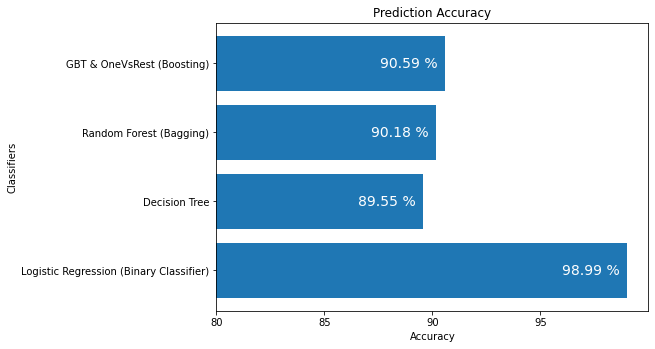

In [183]:
plotAccuracy(mapAccuracy)

As above figure of Prediction Accuracy, we can see that four classification has various prediction accuracy. Multiclass classifications have around 89 to 90 accuracy with point decimal difference. However, we can see that after applying ensamble techniques, accuracy has increased.

Binary classification has nearly 99% accuracy where it predicted the record whether it attacked or normal.

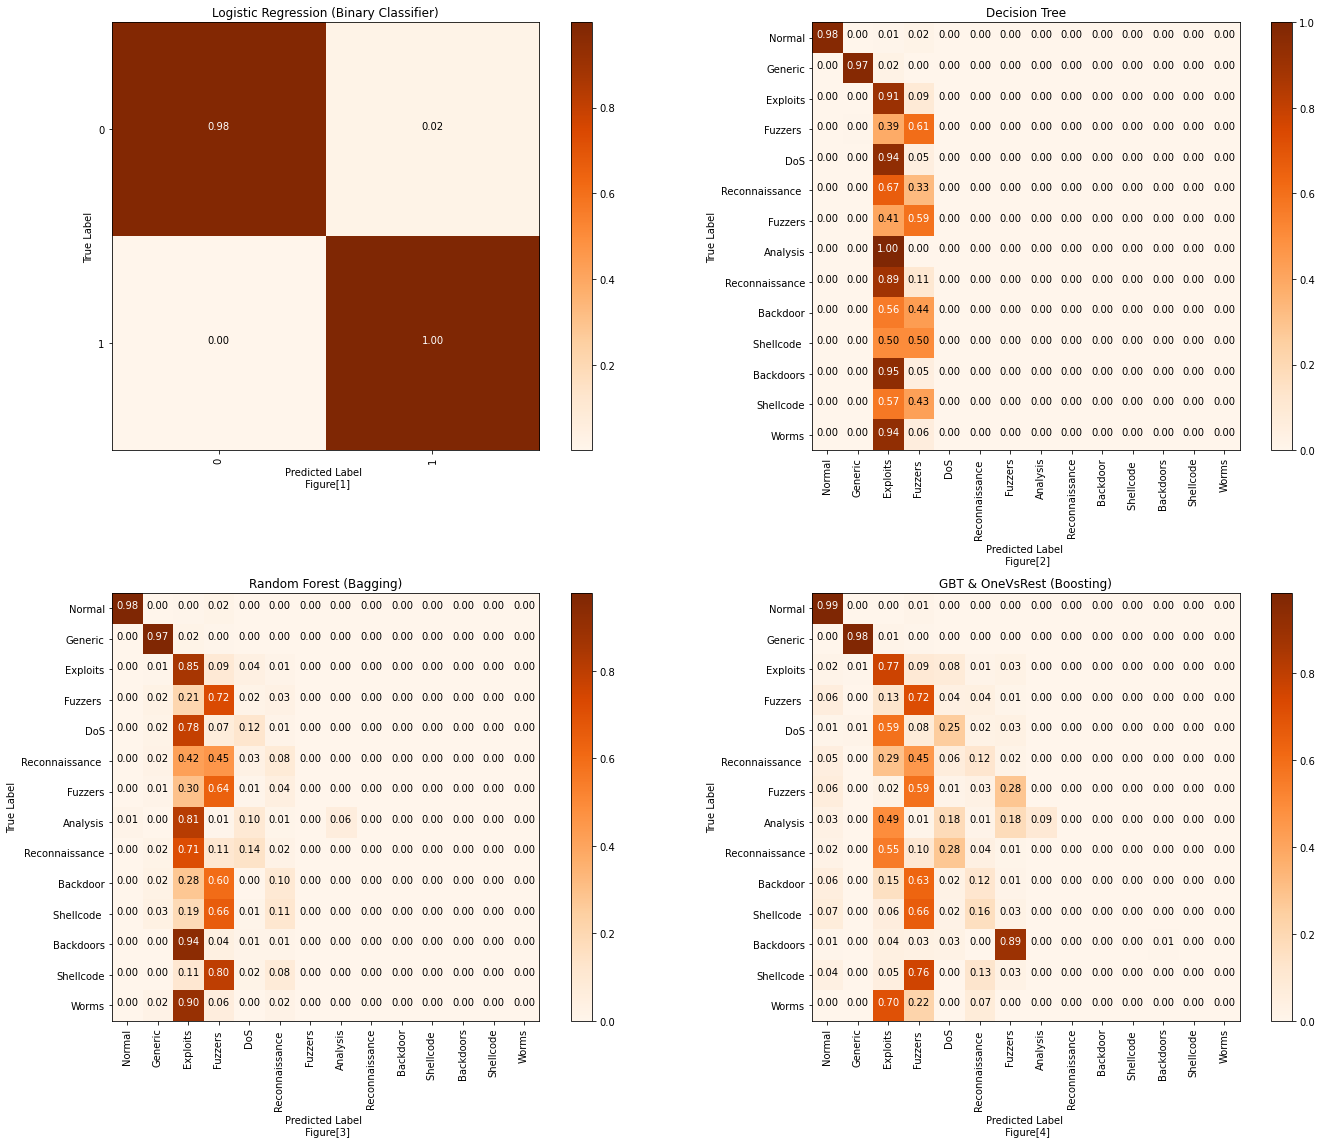

In [184]:
plot_confusion_matrix(listConfusionMatrix)

Above figures are classification matrix. Here, we have four confusion matrix, 1. Logistic Regression, 2. Decision Tree, 3. Random Forest and 4. GBT & OneVsRest.

Binary classification - Logistic regression Figure 1: We can easily see that classifier got predicted wrong on 0 (Normal) where it considered as 1 (Attack)

Multiclass Classification - Figure 2: It cleary shows that classifier got errors in Exploits and Fuzzer attack catagory where Figure 3 and Figure 4: have got error in Exploits, Fuzzers, DoS and Reconaissance.

In [206]:
showClassificationReport(mapReport)

---------------------------------------------------------------------
Logistic Regression (Binary Classifier)
---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    665485
           1       0.89      1.00      0.94     96298

    accuracy                           0.98    761783
   macro avg       0.94      0.99      0.96    761783
weighted avg       0.99      0.98      0.98    761783



---------------------------------------------------------------------
Decision Tree
---------------------------------------------------------------------
                 precision    recall  f1-score   support

         Normal       1.00      0.97      0.98     96128
        Generic       1.00      0.97      0.99     64595
       Exploits       0.46      0.91      0.61     13396
       Fuzzers        0.36      0.60      0.45      5685
            DoS       0.31      0.00      0.00     

Above result shows the classifiers' report that includes Precision, Recall, F1-Score and Accuracy. With the help of these result we can check the True Positives, True Negatives, False Positives and False Negatives of each class (label).

# **Convert ipynb to HTML for Turnitin submission**

---



In [ ]:
# install nbconvert (if facing with conversion error)
!pip3 install nbconvert 

In [ ]:
# convert ipynb to html

!jupyter nbconvert --to html Group23_ML_CN7030

[NbConvertApp] Converting notebook Group23_ML_CN7030.ipynb to html
[NbConvertApp] Writing 399721 bytes to Group23_ML_CN7030.html
